# K-Means Clustering (Product Segmentation)

## Data Description

The dataset consists of 3268 products from Nike and Adidas with features of information including their ratings, discount, sales price, listed price, product name, and the number of reviews.

- Product Name: Name of the product
- Product ID: ID of the product
- Listing Price: Listed price of the product
- Sale Price: Sale price of the product
- Discount: Percentage of discount on the product
- Brand: Brand of the product
- Rating: Rating of the product
- Reviews: Number of reviews for the product

In [7]:
!pip install yellowbrick

     -------------------------------------- 282.6/282.6 kB 3.5 MB/s eta 0:00:00


In [8]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer, SilhouetteVisualizer


In [9]:
# load the dataset
df = pd.read_csv("data_add_nik.csv")

In [10]:
df.shape

(3268, 8)

* The dataset has 3268 rows and 8 columns 

In [4]:
# view a random sample of the dataset
df.sample(n=10, random_state=1)

,Product Name,Product ID,Listing Price,Sale Price,Discount,Brand,Rating,Reviews
255,Women's adidas Originals POD-S3.1 Shoes,CG6188,139.99,69.99,50,Adidas ORIGINALS,3.3,8
1551,Men's adidas Originals Superstar Pure Shoes,FV3013,119.99,119.99,0,Adidas ORIGINALS,3.9,10
1352,Men's adidas Originals Superstar Shoes,FV2806,79.99,79.99,0,Adidas ORIGINALS,4.4,42
1060,Men's adidas Football Nemeziz 19.3 Indoor Shoes,F34411,59.99,35.99,40,Adidas SPORT PERFORMANCE,4.5,75
808,Men's adidas Sport Inspired Court 80s Shoes,EE9676,59.99,35.99,40,Adidas CORE / NEO,4.5,55
836,Men's adidas Running Stargon 1.0 Shoes,CM4935,47.99,38.39,20,Adidas CORE / NEO,3.5,21
2107,Men's adidas Originals Yung-96 Chasm Shoes,EE7238,79.99,47.99,40,Adidas ORIGINALS,3.0,62
3002,Nike SB Air Max Stefan Janoski 2,AQ7477-009,0.00,99.95,0,Nike,2.6,11
2329,Men's adidas Originals Rivalry Low Shoes,FV4287,109.99,109.99,0,Adidas ORIGINALS,2.8,8
602,Men's adidas Sport Inspired Lite Racer RBN Shoes,F36642,55.99,39.19,30,Adidas CORE / NEO,3.0,56


In [50]:
# fix column names
df.columns = [c.replace(" ", "_") for c in df.columns]

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3268 entries, 0 to 3267
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product_Name   3268 non-null   object 
 1   Product_ID     3268 non-null   object 
 2   Listing_Price  3268 non-null   float64
 3   Sale_Price     3268 non-null   float64
 4   Discount       3268 non-null   int64  
 5   Brand          3268 non-null   object 
 6   Rating         3268 non-null   float64
 7   Reviews        3268 non-null   int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 204.4+ KB


**We won't need Product_ID for analysis, so let's drop this column.**

In [52]:
df.drop("Product_ID", axis=1, inplace=True)

In [53]:
# let's check for duplicate observations
df.duplicated().sum()

117

- There are 117 duplicate observations. We will remove them from the data.

In [54]:
df = df[(~df.duplicated())].copy()

**Let's take a look at the summary of the data**

In [55]:
df.describe()

,Listing_Price,Sale_Price,Discount,Rating,Reviews
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000
mean,70.459603,59.831669,27.860997,3.285687,41.891146
std,46.520895,41.737089,22.442753,1.371611,31.283464
min,0.000000,4.490000,0.000000,0.000000,0.000000
25%,45.990000,29.990000,0.000000,2.600000,12.000000
50%,59.990000,45.990000,40.000000,3.600000,40.000000
75%,89.990000,77.990000,50.000000,4.400000,69.000000
max,299.990000,365.000000,60.000000,5.000000,223.000000


**Observations**

- 0 in the listing price indicates missing values.
- The average listing price is 70.46.
- The average sale price is 59.83.
- The average discount is 28%.
- The average rating is 3.3.
- The average number of reviews is 42.

In [56]:
# let's check how many products have listing price 0
(df.Listing_Price == 0).sum()

336

In [57]:
# let's check the products which have listing price 0
df[(df.Listing_Price == 0)]

,Product_Name,Listing_Price,Sale_Price,Discount,Brand,Rating,Reviews
2625,Nike Air Force 1 '07 Essential,0.0,74.95,0,Nike,0.0,0
2626,Nike Air Force 1 '07,0.0,74.95,0,Nike,0.0,0
2627,Nike Air Force 1 Sage Low LX,0.0,99.95,0,Nike,0.0,0
2628,Nike Air Max Dia SE,0.0,99.95,0,Nike,0.0,0
2629,Nike Air Max Verona,0.0,99.95,0,Nike,0.0,0
...,...,...,...,...,...,...,...
3254,Nike Mercurial Vapor 13 Club MG,0.0,49.95,0,Nike,0.0,0
3257,Air Jordan 5 Retro,0.0,159.95,0,Nike,3.3,3
3260,Nike Tiempo Legend 8 Academy TF,0.0,64.95,0,Nike,0.0,0
3262,Nike React Metcon AMP,0.0,139.95,0,Nike,3.0,1


In [58]:
df[(df.Listing_Price == 0)].describe()

,Listing_Price,Sale_Price,Discount,Rating,Reviews
count,336.0,336.000000,336.0,336.000000,336.000000
mean,0.0,112.030506,0.0,2.797619,8.261905
std,0.0,46.238258,0.0,2.150445,19.708393
min,0.0,15.950000,0.0,0.000000,0.000000
25%,0.0,79.950000,0.0,0.000000,0.000000
50%,0.0,109.950000,0.0,3.950000,1.000000
75%,0.0,139.950000,0.0,4.700000,6.000000
max,0.0,365.000000,0.0,5.000000,223.000000


- There are 336 observations that have missing values in the listing price column
- We see that the discount for the products with listing price 0 is 0.
- So, we will replace the listing price with the corresponding sale price for those observations.

In [59]:
df.loc[(df.Listing_Price == 0), ["Listing_Price"]] = df.loc[(df.Listing_Price == 0), ["Sale_Price"]].values

In [60]:
df.Listing_Price.describe()

count    3151.000000
mean       82.405732
std        43.630182
min         8.990000
25%        49.990000
50%        75.990000
75%       109.950000
max       365.000000
Name: Listing_Price, dtype: float64

In [61]:
# checking missing values
df.isna().sum()

Product_Name     0
Listing_Price    0
Sale_Price       0
Discount         0
Brand            0
Rating           0
Reviews          0
dtype: int64

- There are no missing values in the data.

## Exploratory Data Analysis (EDA)

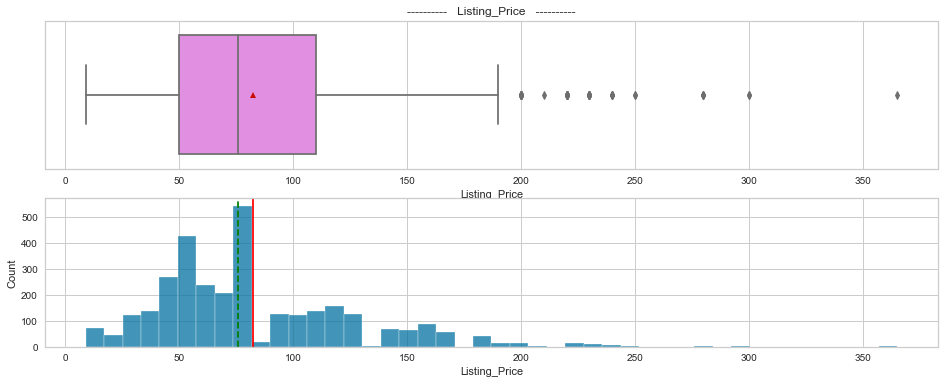

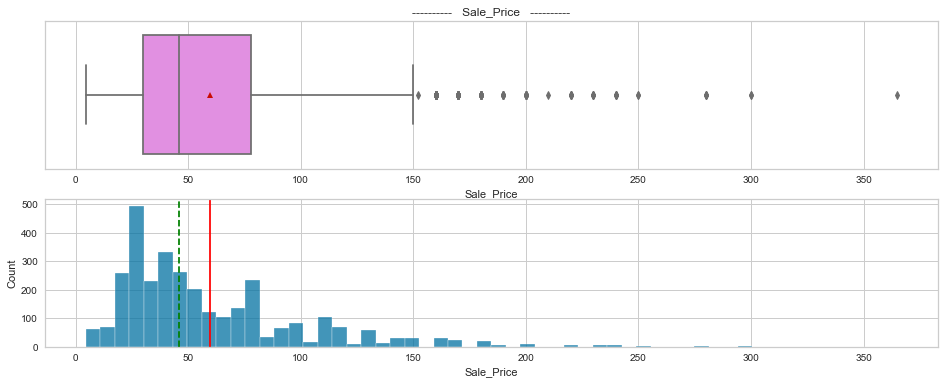

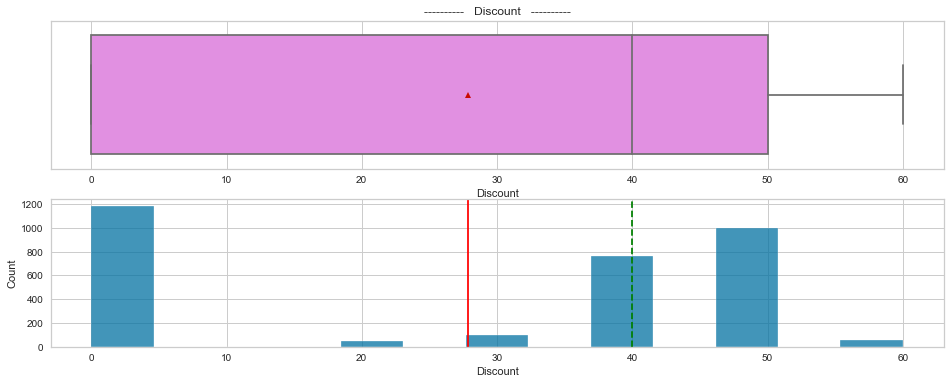

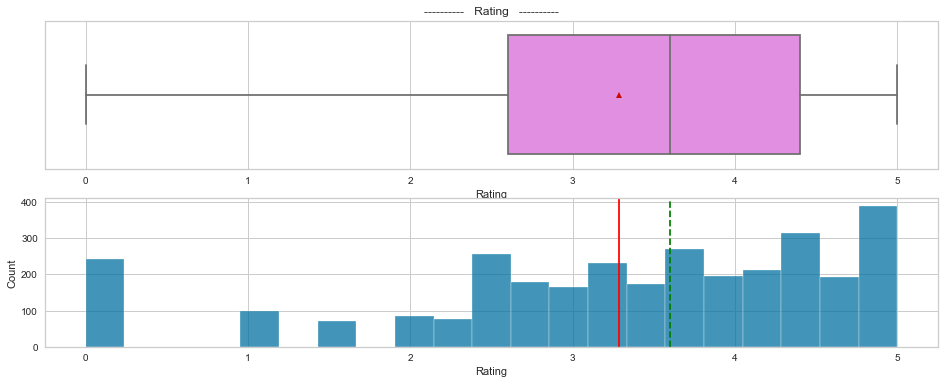

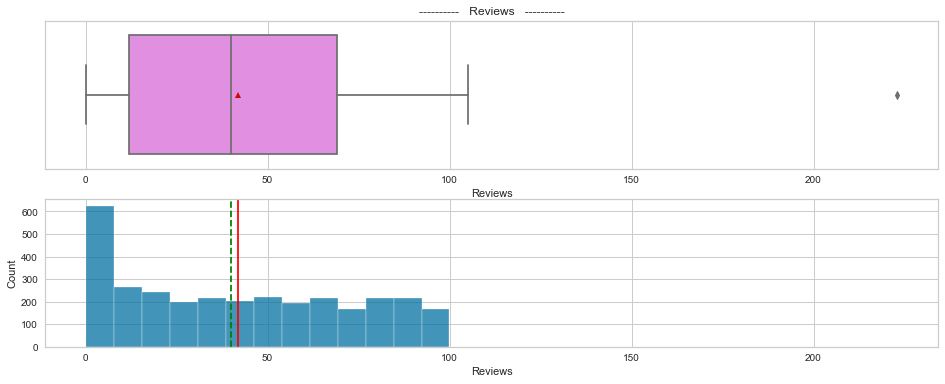

In [18]:
# selecting numerical columns
num_col = df.select_dtypes(include=np.number).columns.tolist()

for col in num_col:
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 1, 1)
    plt.title("----------   " + col + "   ----------")
    sns.boxplot(data=df, x=col, showmeans=True, color="violet")
    plt.subplot(2, 1, 2)
    sns.histplot(data=df, x=col)
    plt.axvline(df[col].mean(), color="red", linestyle="-")
    plt.axvline(df[col].median(), color="green", linestyle="--")
    plt.show()

**Observations**

- Listing price and sale price have right-skewed distributions with upper outliers, which indicates the presence of very expensive products.
- The maximum discount given is 60%.
- Rating is left-skewed and most of the ratings are between 2.5 and 4.5.
- The number of reviews is between 1 and 100, with an outlier value above 200.

In [62]:
def barplot_w_percent(data, feature, perc=False):
    total = len(df["Discount"])  # length of the column
    count = data[feature].nunique()

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(data=data,x=feature,palette="Paired",order=data[feature].value_counts().index[:].sort_values())

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(100 * p.get_height() / total)  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot
        
        # annotate the percentage
        ax.annotate(label, (x, y), ha="center", va="center", size=12, xytext=(0, 5), textcoords="offset points")  

    plt.show()

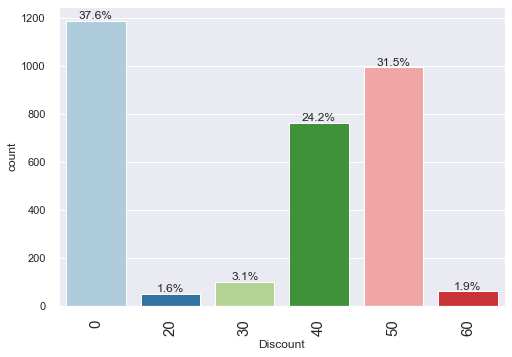

In [63]:
# let's explore discounts further
barplot_w_percent(df, "Discount", perc=True)

**Observations**

- 37.6% of products did not have any discounts.
- More than 50% of the products have 40-50% discount.

## Bivariate Analysis

**Let's check for correlations.**

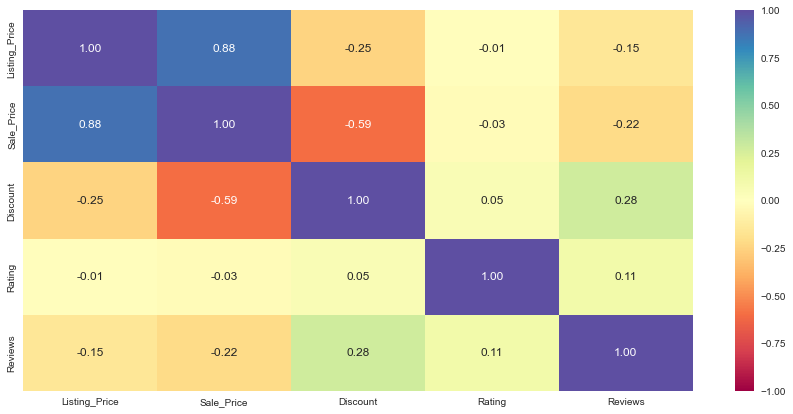

In [21]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations**

- The sale price and the listing price are highly positively correlated, which is obvious.
- Discount is somewhat negatively correlated with listing price or sale price, which indicates that expensive products either have fewer discounts or no discounts at all.

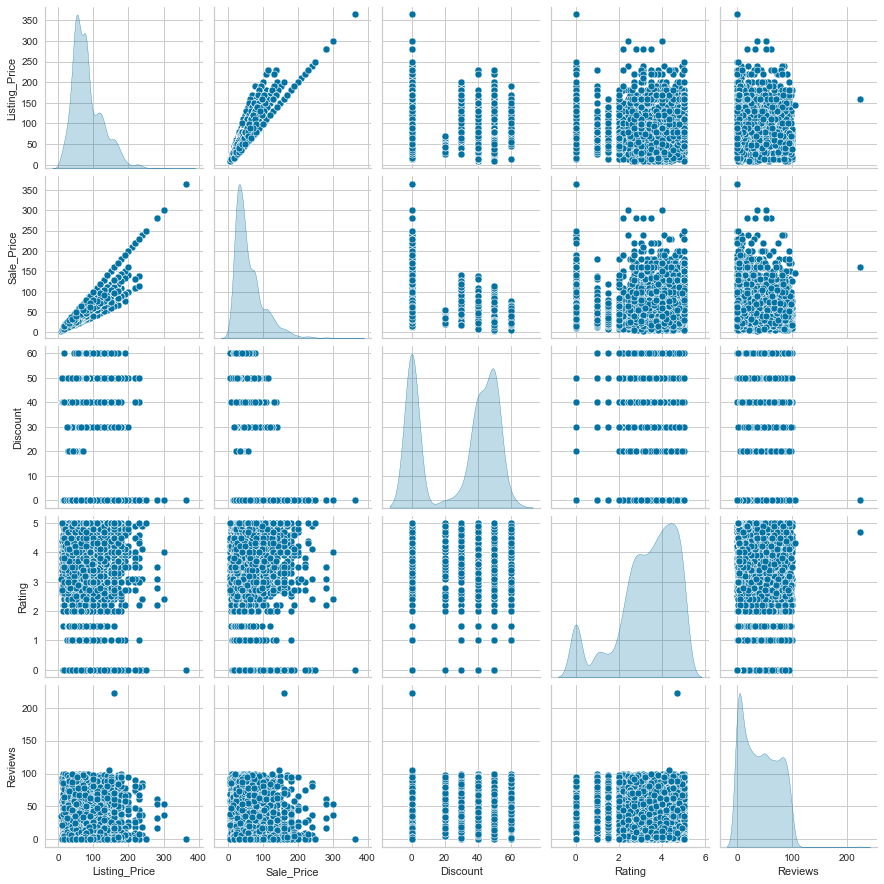

In [22]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- 50-60% discounts are mostly given to products whose listing price is 100 or less.
- Many products have no discount.
- As seen before, most of the products have 100 or fewer reviews.

## Data Preprocessing

In [64]:
# variables used for clustering
num_col = ['Listing_Price', 'Sale_Price', 'Discount', 'Reviews', 'Rating']

In [65]:
# scaling the dataset before clustering
scaler = MinMaxScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [66]:
subset_scaled

array([[0.39605629, 0.1955563 , 0.83333333, 0.1838565 , 0.96      ],
       [0.18819696, 0.09292391, 0.83333333, 0.10762332, 0.66      ],
       [0.00280891, 0.00416077, 0.66666667, 0.16591928, 0.52      ],
       ...,
       [0.42403303, 0.34251477, 0.        , 0.0044843 , 1.        ],
       [0.45212213, 0.45896092, 0.        , 0.01793722, 0.8       ],
       [0.22740934, 0.16221464, 0.        , 0.        , 0.        ]])

In [67]:
# creating a dataframe of the scaled columns
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

In [68]:
subset_scaled_df.describe()

,Listing_Price,Sale_Price,Discount,Reviews,Rating
count,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000
mean,0.206218,0.153509,0.464350,0.187853,0.657137
std,0.122553,0.115772,0.374046,0.140285,0.274322
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.115165,0.070733,0.000000,0.053812,0.520000
50%,0.188197,0.115115,0.666667,0.179372,0.720000
75%,0.283588,0.203878,0.833333,0.309417,0.880000
max,1.000000,1.000000,1.000000,1.000000,1.000000


## K-means Clustering

For n_clusters = 2, WCSS: = 394.25954586514655, Silhouette score: 0.5011663225798444)
For n_clusters = 3, WCSS: = 289.7018761061774, Silhouette score: 0.5113437246235762)
For n_clusters = 4, WCSS: = 221.17202337871146, Silhouette score: 0.3833615424309397)
For n_clusters = 5, WCSS: = 194.99890995785302, Silhouette score: 0.3200625208801727)
For n_clusters = 6, WCSS: = 175.5578280683555, Silhouette score: 0.28976608126220726)
For n_clusters = 7, WCSS: = 159.79406380544066, Silhouette score: 0.28789747223923084)
For n_clusters = 8, WCSS: = 146.81563456101102, Silhouette score: 0.2869371488824038)
For n_clusters = 9, WCSS: = 135.3323618640368, Silhouette score: 0.2770671054445773)


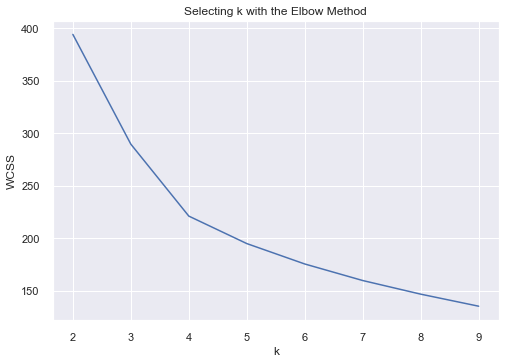

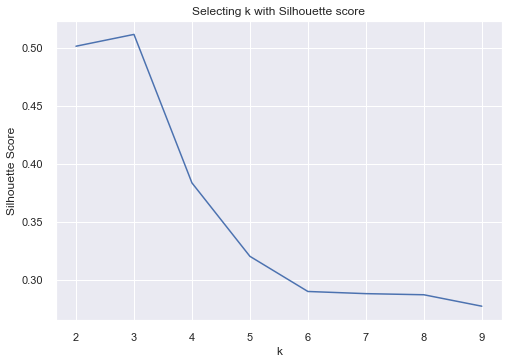

In [69]:
clusters = range(2, 10)
elbow = []
sil_score = []

# perform k-means clustering for different values of k
for k in clusters:
    model = KMeans(n_clusters=k, init = 'k-means++', random_state = 42).fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)

    # within cluster sum of squared distances between each member of the cluster and its centroid
    wcss = model.inertia_
    elbow.append(wcss)
    
    # Silhouette score
    score = silhouette_score(subset_scaled_df, prediction)
    sil_score.append(score)
    print("For n_clusters = {}, WCSS: = {}, Silhouette score: {})".format(k, wcss, score))

plt.plot(clusters, elbow, "bx-")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.title("Selecting k with the Elbow Method")
plt.show()

plt.plot(clusters, sil_score)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Selecting k with Silhouette score")
plt.show()

**Silhouette score for 3 clusers is the largest. So, we will choose 3 as value of k.**

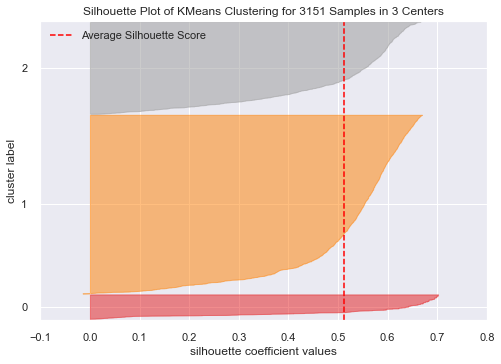

KMeans(n_clusters=3, random_state=42)

In [70]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, init = 'k-means++', random_state = 42)

# visualizing the silhouette score
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(subset_scaled_df)
visualizer.show()

kmeans.fit(subset_scaled_df)

In [71]:
# adding kmeans cluster labels to the original and scaled dataframes
df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_

In [76]:
df.sample(n=10)

,Product_Name,Listing_Price,Sale_Price,Discount,Brand,Rating,Reviews,K_means_segments
1876,Men's adidas Outdoor Geocach II Shoes,49.99,24.99,50,Adidas SPORT PERFORMANCE,4.4,62,1
654,WoMen's adidas TRAINING CRAZYMOVE TR SHOES,59.99,24.00,60,Adidas SPORT PERFORMANCE,2.4,87,1
2281,MEN'S ADIDAS FOOTBALL COPA 18.3 FIRM GROUND BOOTS,59.99,29.99,50,Adidas SPORT PERFORMANCE,4.7,96,1
733,WOMEN'S ADIDAS ORIGINALS NMD_R1 STLT PRIMEKNIT...,159.99,79.99,50,Adidas ORIGINALS,2.8,53,1
1256,Women's adidas Originals Stan Smith Shoes,79.99,47.99,40,Adidas ORIGINALS,2.6,68,1
2731,Nike Phantom Vision 2 Academy Dynamic Fit MG,84.95,84.95,0,Nike,0.0,0,0
476,Men's adidas Running Asweerun Shoes,55.99,33.59,40,Adidas CORE / NEO,3.3,19,1
2186,Men's adidas Originals SL 80 Shoes,99.99,99.99,0,Adidas ORIGINALS,2.2,1,2
81,MEN'S ADIDAS RUNNING HELKIN 3.0 SHOES,45.99,22.99,50,Adidas CORE / NEO,4.0,87,1
2162,Men's adidas Swim Coset II Slippers,14.99,8.99,40,Adidas CORE / NEO,3.0,10,1



x = 'Listing_Price'
y = 'Reviews'
plt.figure(figsize=(20,10))
plt.scatter(subset_scaled_df[subset_scaled_df['K_means_segments']==0][x], subset_scaled_df[subset_scaled_df['K_means_segments']==0][y], s = 50, c = 'red', label = 'Cluster 0')
plt.scatter(subset_scaled_df[subset_scaled_df['K_means_segments']==1][x], subset_scaled_df[subset_scaled_df['K_means_segments']==1][y], s = 50, c = 'blue', label = 'Cluster 1')
plt.scatter(subset_scaled_df[subset_scaled_df['K_means_segments']==2][x], subset_scaled_df[subset_scaled_df['K_means_segments']==2][y], s = 50, c = 'green', label = 'Cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'black', label = 'Centroids')
plt.title('Clusters of products')
plt.xlabel('Rating')
plt.ylabel('Reviews')
plt.legend()
plt.show()

## Cluster Profiling

In [78]:
cluster_profile = df.groupby("K_means_segments").mean()

In [79]:
cluster_profile["count_in_each_segments"] = df.groupby("K_means_segments")["Sale_Price"].count().values

In [80]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="gray", axis=0)

,Listing_Price,Sale_Price,Discount,Rating,Reviews,count_in_each_segments
K_means_segments,,,,,,
0,98.668969,89.216832,3.206107,0.276718,13.041985,262
1,74.174583,40.745275,45.228107,3.373728,49.151023,1907
2,94.051181,89.056558,0.712831,3.917515,35.489817,982


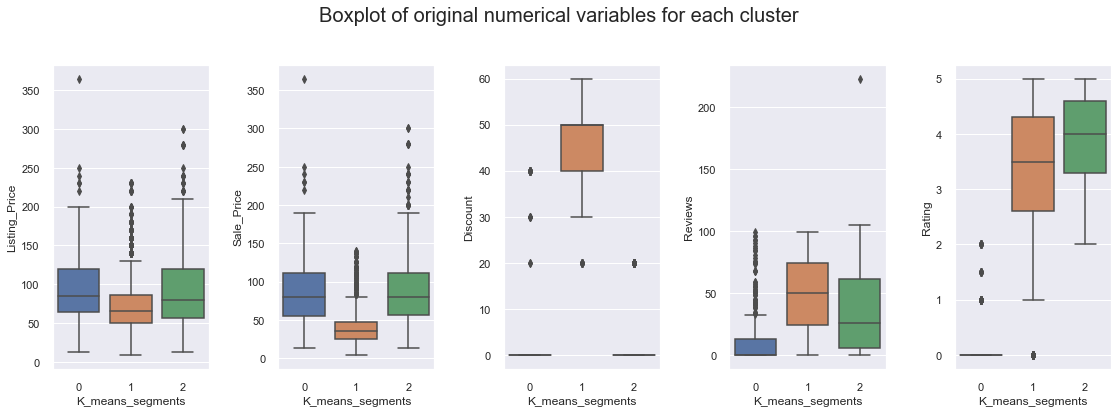

In [81]:
num_plots = len(num_col)
fig, axes = plt.subplots(1, num_plots, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster", fontsize=20)
for i in range(num_plots):
    sns.boxplot(ax=axes[i], y=df[num_col[i]], x=df["K_means_segments"])

fig.tight_layout(pad=2.0)

<AxesSubplot:xlabel='K_means_segments'>

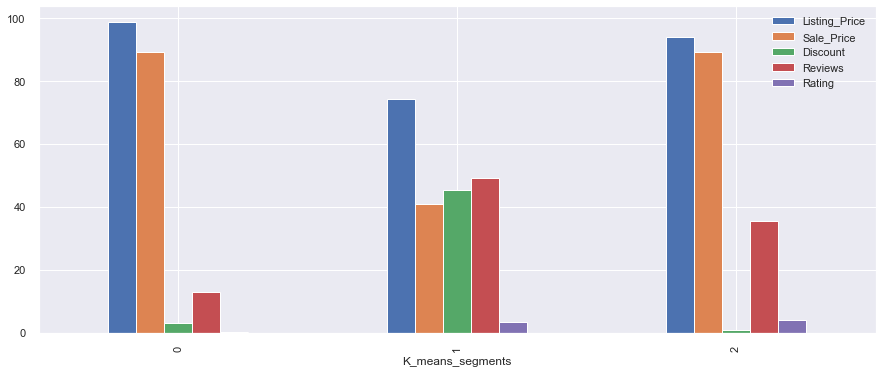

In [82]:
df[num_col+['K_means_segments']].groupby("K_means_segments").mean().plot.bar(figsize=(15, 6))

<AxesSubplot:xlabel='K_means_segments'>

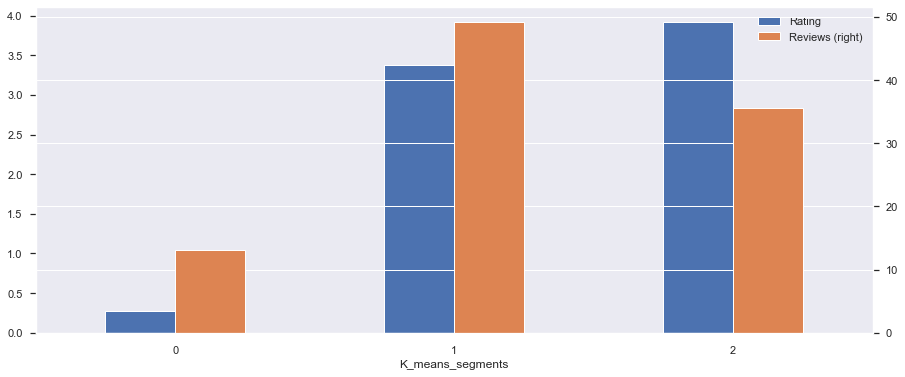

In [83]:
df[["Rating", "Reviews","K_means_segments"]].groupby("K_means_segments").mean().plot(kind='bar', secondary_y='Reviews', rot=0, figsize=(15,6))

## Insights

- **Cluster 0**:
    - This cluster contains expensive premium products, with an average listing price of approximately 100.
    - Low discount of about 3% given.
    - Mean rating of around 0.3 (very low), suggesting customers might not be satisfied with the products.
    - Number of reviews are less as well.
   
- **Cluster 1**:
    - Listing price is low for products in this cluster, and the sale price is lower, as there are heavy discounts on these products.
    - Wide distribution of ratings from 1 to 5.
    - On average, almost 50 reviews are given to products in this cluster.
    
- **Cluster 2**:
    - Although the listing price in this cluster is slightly less compared to cluster 1, the sale price is almost the same as the discount percent is very low in this cluster.
    - The average rating is around 4, which is the highest among the three clusters. This might suggest that the product in this clusters are high quality and are the best selling products.
